In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode(connected=True)

from ipywidgets import interact, interactive, fixed, interact_manual,VBox,HBox,Layout
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

# เกี่ยวกับข้อมูล

ข้อมูลนี้มีธุรกรรมร้านค้าปลีกออนไลน์จาก 38 ประเทศตั้งแต่วันที่ 1 ธันวาคม 2553 ถึง 9 ธันวาคม 2554

## จะวิเคราะห์อะไรบ้าง
- Exploratory data analysis: ซึ่งจะมีการตีความด้วยภาพและจะพยายามทำความเข้าใจพฤติกรรมการซื้อของลูกค้าตามเวลา เเละการทดสอบสมมติฐานทางสถิติด้วย

In [3]:
data = pd.read_csv('DataSet/Data_Segment.csv', index_col=0)
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,CohortIndex,Segment
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,1,Low-Value
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,1,Low-Value
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,1,Low-Value


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351196 entries, 0 to 351195
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     351196 non-null  int64  
 1   StockCode     351196 non-null  object 
 2   Description   351196 non-null  object 
 3   Quantity      351196 non-null  int64  
 4   InvoiceDate   351196 non-null  object 
 5   UnitPrice     351196 non-null  float64
 6   CustomerID    351196 non-null  float64
 7   Country       351196 non-null  object 
 8   TotalPrice    351196 non-null  float64
 9   InvoiceMonth  351196 non-null  object 
 10  CohortMonth   351196 non-null  object 
 11  CohortIndex   351196 non-null  int64  
 12  Segment       351196 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 37.5+ MB


In [5]:
data['InvoiceDate']=pd.to_datetime(data['InvoiceDate'])
data['Sales'] = data.Quantity*data.UnitPrice
data['Year']=data.InvoiceDate.dt.year
data['Month']=data.InvoiceDate.dt.month
data['Week']=data.InvoiceDate.dt.isocalendar().week
data['Year_Month']=data.InvoiceDate.dt.to_period('M')
data['Hour']=data.InvoiceDate.dt.hour
data['Day']=data.InvoiceDate.dt.day
data['weekday'] = data.InvoiceDate.dt.day_name()
data['Quarter'] = data.Month.apply(lambda m:'Q'+str(ceil(m/4)))
data['Date']=pd.to_datetime(data[['Year','Month','Day']])
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,...,Sales,Year,Month,Week,Year_Month,Hour,Day,weekday,Quarter,Date
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,...,15.30,2010,12,48,2010-12,8,1,Wednesday,Q3,2010-12-01
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,20.34,2010,12,48,2010-12,8,1,Wednesday,Q3,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,...,22.00,2010,12,48,2010-12,8,1,Wednesday,Q3,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,20.34,2010,12,48,2010-12,8,1,Wednesday,Q3,2010-12-01
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,20.34,2010,12,48,2010-12,8,1,Wednesday,Q3,2010-12-01


In [6]:
#data.to_csv(r'data_Engi.csv')

In [7]:
sales_by_date = data.groupby(by='Date')['Sales'].sum().reset_index()
fig = go.Figure(data=go.Scatter(x=sales_by_date.Date,y=sales_by_date.Sales
                                ,line = dict(color='black', width=1.5)))
fig.update_layout(xaxis_title="Date",yaxis_title="Sales",title='Daily Sales',template='ggplot2')
fig.show()

- จากราฟจะเห็นแนวโน้มที่เพิ่มขึ้น เป็นเรื่องยากที่จะคาดเดาว่าการเพิ่มขึ้นอย่างรวดเร็วนี้เกิดจากกิจกรรมหรือการส่งเสริมการขายใดๆ

In [8]:
sales_by_hour = data.groupby(by='Hour')['Sales'].sum().reset_index()
sales_by_weekday = data.groupby(by='weekday')['Sales'].sum().reset_index()
print(sales_by_hour.mean(),"\n")
print(sales_by_weekday.mean())

Hour         13.000000
Sales    393568.246667
dtype: float64 

Sales    983920.616667
dtype: float64


In [9]:
fig = make_subplots(rows=1, cols=2,subplot_titles=("Total Hourly Sales", "Total Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()


del [sales_by_hour,sales_by_weekday]

- ยอดขายรายชั่วโมงมีค่าเฉลี่ย 400k เเละช่วงเวลาเที่ยงจะเป็นช่วงพีคของการขาย 979k
- ไม่มีรูปแบบการขายที่ชาญฉลาดในแต่ละวันในหนึ่งเดือน
- ไม่มีธุรกิจในวันเสาร์
- ยอดขายเฉลี่ยจะสม่ำเสมอตั้งแต่วันจันทร์ถึงวันศุกร์
- เริ่มขายเวลา 6 โมงเช้าและสิ้นสุดเวลา 20.00 น.
- ช่วงพีคของการขายคือระหว่าง 10.00 น. ถึง 15.00 น.

In [10]:
customer_by_month1 = data.groupby('CustomerID')['Date'].min().reset_index()
customer_by_month1['days'] = pd.TimedeltaIndex(customer_by_month1.Date.dt.day,unit="D")
customer_by_month1['Month'] = customer_by_month1.Date- customer_by_month1.days+pd.DateOffset(days=1)
customer_by_month1['Quarter_acquisition'] = customer_by_month1['Month'].dt.quarter.apply(lambda x:'Q'+str(x))
customer_by_month1['Year_acquisition'] = customer_by_month1['Month'].dt.year
customer_by_month = data.groupby(by = customer_by_month1.Month)['CustomerID'].size().reset_index()
customer_by_month.sort_values(by ='Month',ascending=True,inplace=True)
customer_by_month['cum_customer'] = np.cumsum(customer_by_month.CustomerID)
customer_by_month['Month_1'] = customer_by_month['Month'].dt.strftime('%b-%y')

In [11]:
customer_by_month1.head()

,CustomerID,Date,days,Month,Quarter_acquisition,Year_acquisition
0,12747.0,2010-12-05,5 days,2010-12-01,Q4,2010
1,12748.0,2010-12-01,1 days,2010-12-01,Q4,2010
2,12749.0,2011-05-10,10 days,2011-05-01,Q2,2011
3,12820.0,2011-01-17,17 days,2011-01-01,Q1,2011
4,12821.0,2011-05-09,9 days,2011-05-01,Q2,2011


In [12]:
customer_by_month

,Month,CustomerID,cum_customer,Month_1
0,2010-12-01,805,805,Dec-10
1,2011-01-01,351,1156,Jan-11
2,2011-02-01,335,1491,Feb-11
3,2011-03-01,416,1907,Mar-11
4,2011-04-01,274,2181,Apr-11
...,...,...,...,...
8,2011-08-01,143,2958,Aug-11
9,2011-09-01,274,3232,Sep-11
10,2011-10-01,322,3554,Oct-11
11,2011-11-01,296,3850,Nov-11


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

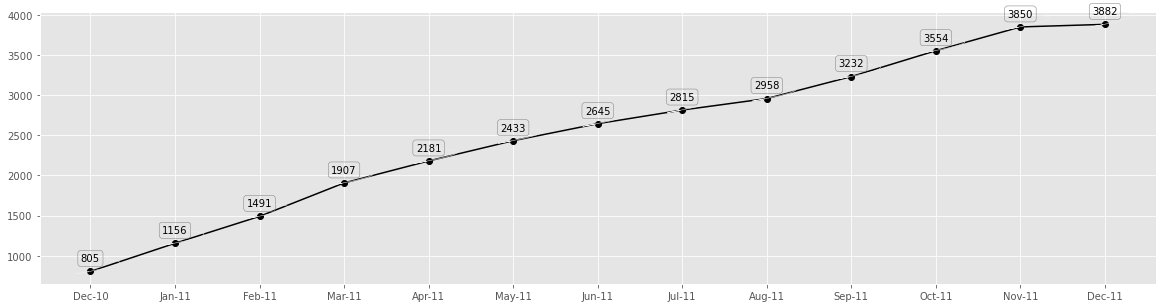

In [13]:
plt.style.use('ggplot')
plt.figure(figsize=(20,5))
plt.plot(customer_by_month.Month_1,customer_by_month.cum_customer,'bo-',color='black')

# zip joins x and y coordinates in pairs
for d,c in zip(customer_by_month['Month_1'],customer_by_month['cum_customer']):

    label = "{:.0f}".format(c)

    plt.annotate(label, 
                 (d,c), 
                 textcoords="offset points"
                 , bbox=dict(boxstyle="round", fc="none", ec="gray")
                 ,arrowprops=dict(arrowstyle="-",connectionstyle="angle,angleA=0,angleB=10,rad=90")
                 ,xytext=(0,10),
                 ha='center') 
plt.show()

del customer_by_month

- การวิเคราะห์ด้านล่างแสดงจำนวนการมาของลูกค้าทุกเดือน และในปลายเดือนพฤศจิกายน 2554 มีประมาณ ลูกค้า 3.8k รายที่ทำการซื้อในช่วงเวลาที่กำหนด

In [14]:
customer_sales = data.groupby(by = ['CustomerID','Year','Quarter'])['Sales'].sum().reset_index()
customer_sales = customer_sales.merge(customer_by_month1[['CustomerID','Quarter_acquisition','Year_acquisition']]
                                      ,on ='CustomerID',how='inner')
customer_sales_acquisition = customer_sales.groupby(by=['Year','Quarter','Year_acquisition','Quarter_acquisition'])['Sales'].sum().reset_index()
customer_sales_acquisition['Sales_Year_quarter'] =customer_sales_acquisition[['Year','Quarter']].apply(lambda row:str(row.Year)+'-'+row.Quarter,axis=1)
customer_sales_acquisition['Acquisition_Year_quarter'] =customer_sales_acquisition[['Year_acquisition','Quarter_acquisition']].apply(lambda row:str(row.Year_acquisition)+'-'+row.Quarter_acquisition,axis=1)
customer_sales_acquisition.drop(columns =['Year','Quarter','Year_acquisition','Quarter_acquisition'],inplace=True)
df = customer_sales_acquisition.pivot(index='Sales_Year_quarter',columns =['Acquisition_Year_quarter']).fillna(0).reset_index()

In [15]:
df.iloc[:,0][0] = '2010-Q4'


In [16]:
df

Sales_Year_quarter      Sales                        \
Acquisition_Year_quarter                       2010-Q4    2011-Q1    2011-Q2   
0                                   2010-Q4  418826.10       0.00       0.00   
1                                   2011-Q1  655359.48  597262.65  104121.38   
2                                   2011-Q2  744501.09  508262.86  308985.65   
3                                   2011-Q3  970119.89  580891.56  249284.53   

                                                
Acquisition_Year_quarter    2011-Q3    2011-Q4  
0                              0.00       0.00  
1                              0.00       0.00  
2                         121466.15       0.00  
3                         334396.52  310045.84

In [17]:
fig = go.Figure(data=[
    go.Bar(name='First Order 2010-Q4', x=df.Sales_Year_quarter, y=df.iloc[:,1],marker_color='lightslategrey'),
    go.Bar(name='First Order 2011-Q1', x=df.Sales_Year_quarter, y=df.iloc[:,2],marker_color='lightblue'),
    go.Bar(name='First Order 2011-Q2', x=df.Sales_Year_quarter, y=df.iloc[:,3],marker_color='seagreen'),
    go.Bar(name='First Order 2011-Q3', x=df.Sales_Year_quarter, y=df.iloc[:,4],marker_color='orange')
])
fig.update_layout(barmode='stack',template='ggplot2')
fig.show()

del [customer_sales_acquisition, df,customer_sales]

- แผนภูมิแสดงให้เห็นว่าไตรมาสของการซื้อของลูกค้าและการซื้อทั้งหมดของพวกเขาในปีต่อ ๆ ไป ลูกค้าที่ซื้อครั้งแรกในไตรมาสที่ 4 ของเดือนธันวาคม 2553 มีส่วนสนับสนุนอย่างมากในไตรมาสต่อๆ ไปของปี 2554 ข้อสังเกตเดียวกันนี้ใช้กับลูกค้าที่มาซื้อในไตรมาสแรกของปี 2554

In [18]:
cust_date =data.loc[~data.CustomerID.isna(),['CustomerID','Date']].drop_duplicates()
cust_date.sort_values(by=['CustomerID','Date'],inplace=True)
cust_date['rnk'] = cust_date.groupby(by='CustomerID')['Date'].transform('rank', method='dense')
cust_date = cust_date[cust_date.rnk<=2]
cust_date['Purchase'] = cust_date.rnk.map({1:'First Purchase',2:'Second Purchase'})

cust_purchase= cust_date.pivot(index='CustomerID',columns=['Purchase'],values='Date').reset_index()

cust_purchase['gap']=(cust_purchase['Second Purchase']- cust_purchase['First Purchase'])/ np.timedelta64(30, 'D')
cust_purchase['gap'] = cust_purchase['gap'].fillna(0).apply(lambda x:ceil(x))

days = pd.TimedeltaIndex(cust_purchase['First Purchase'].dt.day,unit="D")

cust_purchase['First_Purchase_month']=cust_purchase['First Purchase']- days+pd.DateOffset(days=1)
cust_purchase_grid = cust_purchase.pivot_table(index=['First_Purchase_month'],columns =['gap'],values='CustomerID',aggfunc='count').fillna(0)
cust_purchase_grid = cust_purchase_grid.sort_index( ascending=False)

fig = go.Figure(data=go.Heatmap(z=cust_purchase_grid
                                ,y=cust_purchase_grid.index,
                   x=cust_purchase_grid.columns.tolist(),
                   hoverongaps = True,colorscale='balance'))
fig.update_xaxes(side="top",showticklabels = True,ticktext= cust_purchase_grid.columns.tolist())
fig.update_layout(height=600,width=800,xaxis_title="Future Month of next Purchase after making first purchase"
                  ,yaxis_title="Month of 1st Purchase",
           yaxis=dict(autorange='reversed',showticklabels = True)
                  ,autosize=False,template='ggplot2')

fig.show()

del [cust_date,cust_purchase,days,cust_purchase_grid]

In [19]:
sales_by_hour = data.groupby(by='Hour')['Sales'].mean().reset_index()
sales_by_weekday = data.groupby(by='weekday')['Sales'].mean().reset_index()

fig = make_subplots(rows=1, cols=2,subplot_titles=("Avg Hourly Sales", "Avg Sales by Weekday"))
fig.add_trace(go.Bar(y=sales_by_hour.Hour, x=sales_by_hour.Sales,orientation='h'),row=1, col=1)
fig.add_trace(go.Bar(x=sales_by_weekday.weekday, y=sales_by_weekday.Sales),row=1, col=2)
fig.update_layout(height=700, width=800,template='ggplot2')
fig.update_xaxes(title_text="Sales", row=1, col=1)
fig.update_xaxes(title_text="Weekday", row=1, col=2)
fig.update_yaxes(title_text="Hours", row=1, col=1)
fig.update_yaxes(title_text="Sales", row=1, col=2)
fig.show()

del [sales_by_hour,sales_by_weekday]

Hour

H0: Sales is same across hours from 6 AM to 10 PM

Ha: Sales varies by hour of the day

We can see that p value is less than .05 (a confidence threshold point to take risk). Hence, we can reject null hypothesis and concluded that average sales vary by hour of the day

In [20]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols('Sales ~ C(Hour)',data=data).fit()
#ols.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)
del [table,model]

                sum_sq        df           F  PR(>F)
C(Hour)   4.656258e+06      14.0  371.036337     0.0
Residual  3.147919e+08  351181.0         NaN     NaN


Hour

H0: Sales is same across hours from 6 AM to 10 PM

Ha: Sales varies by hour of the day

We can see that p value is less than .05 (a confidence threshold point to take risk). Hence, we can reject null hypothesis and concluded that average sales vary by hour of the day

In [21]:
model = ols('Sales ~ C(weekday)',data=data).fit()
#moore_lm.summary()
table = sm.stats.anova_lm(model, typ=2)
print(table)

del [table,model]

                  sum_sq        df         F  PR(>F)
C(weekday)  2.325112e+06       5.0  514.9774     0.0
Residual    3.171231e+08  351190.0       NaN     NaN
